# Задание 1

In [1]:
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import math

from statsmodels.stats.proportion import proportion_confint, proportions_ztest

import scipy

In [2]:
grp = pd.read_csv('groups.csv', names=['student_id', 'grp'], header=0, sep=';')
act = pd.read_csv('active_studs.csv')
chk = pd.read_csv('checks.csv', sep=';')

In [3]:
#Проверяем дубликаты, пропущенные значения
print(grp.duplicated().value_counts(), '\n')
print(act.duplicated().value_counts(), '\n')
print(chk.duplicated().value_counts(), '\n')
print(grp.info(), '\n')
print(act.info(), '\n')
print(chk.info(), '\n')

False    74576
dtype: int64 

False    8341
dtype: int64 

False    541
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74576 entries, 0 to 74575
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   student_id  74576 non-null  int64 
 1   grp         74576 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB
N

План на задание: 

1) Сравнить конверсию в оплату и проверить ее стат значимость

2) То же самое сделать со средним чеком

In [4]:
act_grp = pd.merge(grp, act, how='right', on='student_id')
act_chk = pd.merge(act_grp, chk, how='inner', on='student_id')
act_chk2 = pd.merge(act_grp, chk, how='left', on='student_id')

Стоит заметить, что при внутреннем соединении таблиц c пользователями, которые заходили на платформу во время эксперимента, и оплатами в дни проведения эксперимента не все оплаты "нашли" активных пользователей (возможно у них оплата прошла автоматическим реккурентным платежом, но также возможны другие причины). 

Не очень понятно, как это интерпретировать, но одно можно сказать точно - эти юзеры точно не видели новую/старую форму оплаты. Поэтому позволю себе допущение - в будущем их не учитывать.

In [5]:
# Готовим и преобразуем данные для последующего анализа
# участники эксперимента и конверсии
act_chk2.rev = act_chk2.rev.astype('float64')
grp_a = act_chk2[act_chk2['grp'] == 'A'].rev.apply(lambda x: 1 if x > 0 else 0)
grp_b = act_chk2[act_chk2['grp'] == 'B'].rev.apply(lambda x: 1 if x > 0 else 0)

# чеки
rev_a = act_chk[act_chk['grp'] == 'A'].rev
rev_b = act_chk[act_chk['grp'] == 'B'].rev

In [6]:
results = pd.DataFrame({"Всего в эксперименте" : [grp.groupby('grp').count().iloc[0,0], grp.groupby('grp').count().iloc[1,0]],
                        "Эксперимент разыгрался, чел." : [len(grp_a), len(grp_b)],
                        "Эксперимент разыгрался, %" : [round(len(grp_a) / grp.groupby('grp').count().iloc[0,0], 3), 
                                                       round(len(grp_b) / grp.groupby('grp').count().iloc[1,0], 3)],
                        "Оплатили, чел." : [sum(grp_a), sum(grp_b)],
                        "Оплатили, %" : [round(sum(grp_a) / len(grp_a), 3), round(sum(grp_b) / len(grp_b), 3)],
                        "Средний чек" : [round(np.mean(rev_a)), round(np.mean(rev_b))] }, index = ['A', 'B'])

In [7]:
results

,Всего в эксперименте,"Эксперимент разыгрался, чел.","Эксперимент разыгрался, %","Оплатили, чел.","Оплатили, %",Средний чек
A,14693,1538,0.105,78,0.051,934.0
B,59883,6803,0.114,314,0.046,1258.0


In [8]:
# В интернетах нашел функцию, которая рассчитывает минимальную выборку на каждую группу для АВ-тестирования
def calc_sample_size(alpha, power, p, pct_mde):
    # Based on https://www.evanmiller.org/ab-testing/sample-size.html
    delta = p * pct_mde
    t_alpha2 = scipy.stats.norm.ppf(1.0-alpha/2)
    t_beta = scipy.stats.norm.ppf(power)

    sd1 = np.sqrt(2 * p * (1.0 - p))
    sd2 = np.sqrt(p * (1.0 - p) + (p + delta) * (1.0 - p - delta))

    return (t_alpha2 * sd1 + t_beta * sd2) * (t_alpha2 * sd1 + t_beta * sd2) / (delta * delta)

In [9]:
round(calc_sample_size(0.05, 0.8, 0.05, 0.2))

7663.0

Что мы видим: для базовой конверсии в 5% и минимально ощутимом/обнаруживаемым эффектом в 20% при alpha=5%, power=80% (ошибки 1 и 2 рода) получаем 7663 наблюдения на каждую выборку.

В нашем АВ-тесте эксперимент разыгрался для 1538 и 6803 пользователей под А и В группы соответственно - рано делать выводы, необходимо ждать до тех пор, пока каждая выборка не разыграется для 7663 юзеров. На этом можно было бы заканчивать задание, но думаю, что надо показать на имеющихся данных дальнейший анализ. 

In [10]:
# Начнем по порядку - сначала проанализируем конверсию в оплату - видим распределение Бернулли,
# будем использовать соответствующие методы из стат пакетов
grp_a

2       0
5       0
6       0
8       0
14      0
       ..
8316    0
8326    1
8332    0
8337    0
8339    0
Name: rev, Length: 1538, dtype: int64

In [11]:
# построим доверительные интервалы для полученных конверсий, видим, что один из них полностью входит в диапазон 
# другого интервала, уже здесь можно сказать о том, что значимых изменений нет, но пойдем дальше
print(proportion_confint(sum(grp_a), grp_a.shape[0], method='binom_test'))
print(proportion_confint(sum(grp_b), grp_b.shape[0], method='binom_test'))

(0.040535233739219856, 0.06297593758724482)
(0.04135818392239928, 0.05142797226897443)


Для проверки соответсвующей гипотезы формально обозначим, что мы проверяем:

$H_0\colon$ Конверсия в оплату между новой и старой версией значимо не отличается

$H_1\colon$ Отличается (двусторонняя альтернатива, поскольку мы не можем заранее знать, какой будет перфоманс)

In [12]:
# для проверки нашей гипотезы будем использовать z-критерий для двух долей 
proportions_ztest([sum(grp_a), sum(grp_b)], [grp_a.shape[0], grp_b.shape[0]])[1]

0.445470284371589

#### P-value равен 0.45 - нулевая гипотеза уверенно не отвергается

Новый вариант не отличается от старого на уровне значимости 0,05 (да и вообще на любом адекватном)

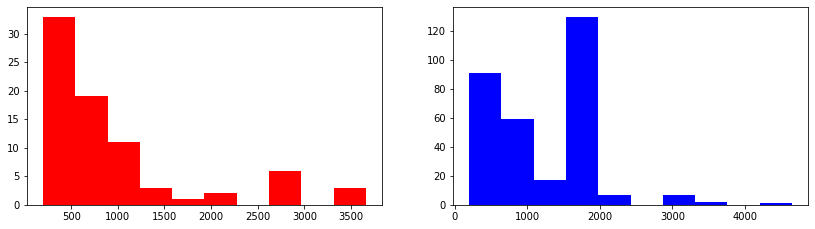

In [13]:
# Для полноты анализа проверим гипотезу о равенстве средних чеков между 2 вариантами, 
# для этого посмотрим на распределение чеков

plt.figure(figsize=(14,8))
plt.subplot(2, 2, 1)
plt.hist(rev_a, color = 'r')
plt.subplot(2, 2, 2)
plt.hist(rev_b, color = 'b')
plt.show()

In [14]:
# Судя по графикам, распределение не очень похоже на нормальное, для этого проведем тест Шапиро-Уилка и определим
# нормальность распределения - это нам необходимо для дальнейшего выбора критерия проверки ср чеков
# Нулевая гипотеза: распределение нормальное, Альтернативная: средние чеки распределены не нормально 

print(scipy.stats.shapiro(rev_a)[1])
print(scipy.stats.shapiro(rev_b)[1])

# Получили очень маленькие значения p-value - нулевая гипотеза о нормальности распределения уверенно отвергается 
# по обеим выборкам 

1.4986822893803264e-10
1.5437024585965894e-16


Поскольку мы имеем дело с ненормальным распределением, для сравнения двух независимых выборок применим критерий Манна-Уитни 

$H_0\colon$ Средние чеки одинаковы для новой и старой механики оплаты на сайте

$H_1\colon$ Не одинаковы

In [15]:
scipy.stats.mannwhitneyu(rev_a, rev_b)

MannwhitneyuResult(statistic=9001.0, pvalue=0.0001255696915703461)

#### p-value равен 0.0001 - нулевая гипотеза уверенно отвергается 

В новой механике оплаты средний чек больше на уровне значимости 0.01 / 0.05

Немного странно получилось, однако есть нюансы:

1) В выборочных данных не должно быть совпадающих значений (все числа — разные) или таких совпадений должно быть очень мало (до 10), наша выборка этому явно не соответствует 

2) При объеме выборки больше 60 штук критерий Манна-Уитни статистика апроксимируется нормальным распределением - в данном случае нет смысла применять данный критерий 

Что делать? Есть 2 вариант дальнейшего развития событий: 1) открутить тест до минимально необходимого объема выборки 2) применить бутстрап 



Представим, что мы открутили наш АВ-тест и получили нормальное распределение (применили критерий Шапиро-Уилка, построили КуКу-plot), тогда мы сможем применить критерий Стьюдента, сформулируем гипотезы:

$H_0\colon$ средние значения оплат одинаковы для обеих групп

$H_0\colon$ не одинаковы.

In [16]:
scipy.stats.ttest_ind(rev_a, rev_b, equal_var = False)

# "отвергаем нулевую гипотезу - средние чеки значимо отличаются" 

Ttest_indResult(statistic=-2.861689755269415, pvalue=0.0050697340128001145)

# Задание 3

In [52]:
df = pd.DataFrame({'Babylon': [60000, 80000, 100000, 200000, 200000]}, 
                  index=['1700 BC', '1200 BC', '1000 BC', '600 BC', '500 BC'])
class BaseGraph():
    src = df
    name = 'Meganame'
    xlabel = 'Year before Christ'
    ylabel = 'Population'
    label = 'Babylon'
    
    def plot(self):
        plt.plot(self.src, label=self.label)
        plt.title(self.name)
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        plt.legend(loc='best')
        plt.show()

class BarGraph(BaseGraph):
    def plot(self):
        plt.bar(self.src.index, self.src.Babylon.values, label=self.label)
        plt.title(self.name)
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        plt.legend(loc='best')
        plt.show()

In [53]:
# Создадим новые объекты
a = BaseGraph()
b = BarGraph()

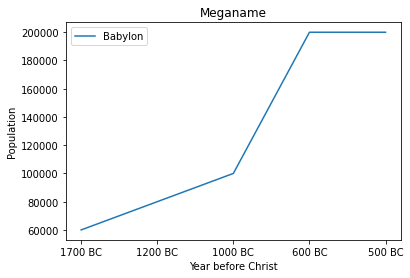

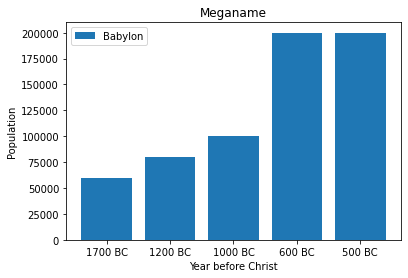

In [54]:
# Проверим правильность построения соответствующих графиков
a.plot()
b.plot()

{'name': 'Bar Chart name'}


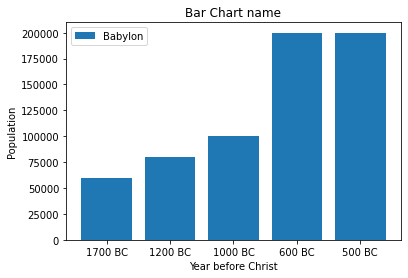

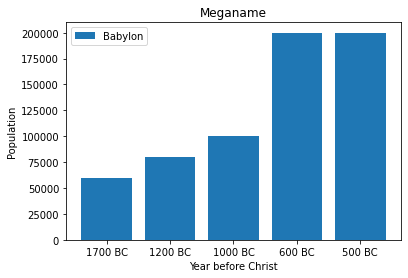

In [61]:
# поменяем один параметр объекта b и увидим, что он записался к нашему объекту b, что также видно на графике
b.name = 'Bar Chart name'
print(b.__dict__)
b.plot()

# Создадим еще один объект аналогичного класса и увидим, что его атрибуты не поменялись 
c = BarGraph()
c.plot()

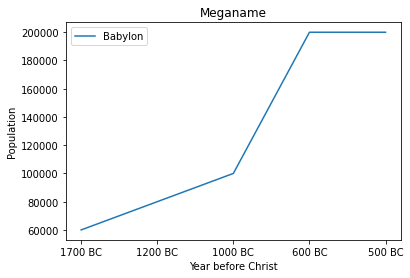

In [60]:
# Название графика из метода первого класса не поменялось 
a.plot()